In [1]:
!pip install wordcloud

In [2]:
!pip install xgboost

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords

STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import GridSearchCV
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
data = pd.read_csv(r"C:\Users\Lenovo\Downloads\archive (1)\amazon_alexa.tsv", delimiter='\t', quoting=3)
data.shape

(3150, 5)

In [5]:
data.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [6]:
data.columns.values

array(['rating', 'date', 'variation', 'verified_reviews', 'feedback'],
      dtype=object)

In [7]:
data.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    0
feedback            0
dtype: int64

In [8]:
data[data['verified_reviews'].isna()==True]

,rating,date,variation,verified_reviews,feedback


In [9]:
data['length'] = data['verified_reviews'].apply(len)

In [10]:
data.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [11]:
data.dtypes

rating               int64
date                object
variation           object
verified_reviews    object
feedback             int64
length               int64
dtype: object

In [12]:
data['rating'].value_counts()

5    2286
4     455
1     161
3     152
2      96
Name: rating, dtype: int64

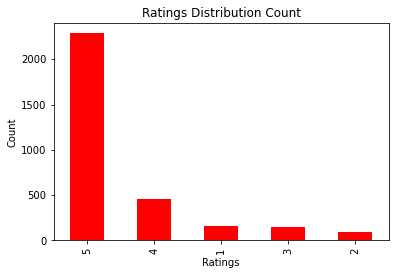

In [13]:
data['rating'].value_counts().plot.bar(color='red')
plt.title('Ratings Distribution Count')
plt.xlabel('Ratings')
plt.ylabel('Count')

plt.show()

In [14]:
(data['rating'].value_counts() / data.shape[0] * 100).round(2)

5    72.57
4    14.44
1     5.11
3     4.83
2     3.05
Name: rating, dtype: float64

In [15]:
data['feedback'].value_counts()

1    2893
0     257
Name: feedback, dtype: int64

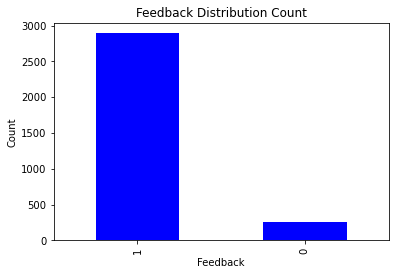

In [16]:
data['feedback'].value_counts().plot.bar(color='blue')
plt.title('Feedback Distribution Count')
plt.xlabel('Feedback')
plt.ylabel('Count')

plt.show()

In [17]:
(data['feedback'].value_counts() / data.shape[0] * 100).round(2)

1    91.84
0     8.16
Name: feedback, dtype: float64

In [18]:
data[data['feedback'] == 0]['rating'].value_counts()

1    161
2     96
Name: rating, dtype: int64

In [19]:
data[data['feedback'] == 1]['rating'].value_counts()

5    2286
4     455
3     152
Name: rating, dtype: int64

In [20]:
data['variation'].value_counts()

Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
White                            91
Sandstone Fabric                 90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: variation, dtype: int64

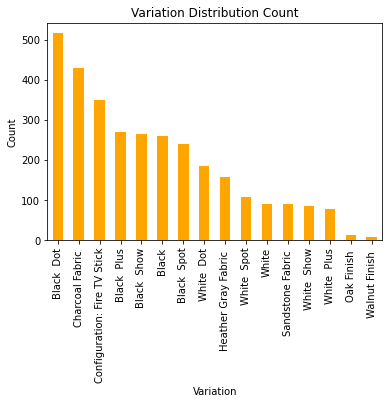

In [21]:
data['variation'].value_counts().plot.bar(color='orange')
plt.title('Variation Distribution Count')
plt.xlabel('Variation')
plt.ylabel('Count')

plt.show()

In [22]:
(data['variation'].value_counts() / data.shape[0] * 100).round(2)

Black  Dot                      16.38
Charcoal Fabric                 13.65
Configuration: Fire TV Stick    11.11
Black  Plus                      8.57
Black  Show                      8.41
Black                            8.29
Black  Spot                      7.65
White  Dot                       5.84
Heather Gray Fabric              4.98
White  Spot                      3.46
White                            2.89
Sandstone Fabric                 2.86
White  Show                      2.70
White  Plus                      2.48
Oak Finish                       0.44
Walnut Finish                    0.29
Name: variation, dtype: float64

In [23]:
data.groupby('variation')['rating'].mean()

variation
Black                           4.233716
Black  Dot                      4.453488
Black  Plus                     4.370370
Black  Show                     4.490566
Black  Spot                     4.311203
Charcoal Fabric                 4.730233
Configuration: Fire TV Stick    4.591429
Heather Gray Fabric             4.694268
Oak Finish                      4.857143
Sandstone Fabric                4.355556
Walnut Finish                   4.888889
White                           4.142857
White  Dot                      4.423913
White  Plus                     4.358974
White  Show                     4.282353
White  Spot                     4.311927
Name: rating, dtype: float64

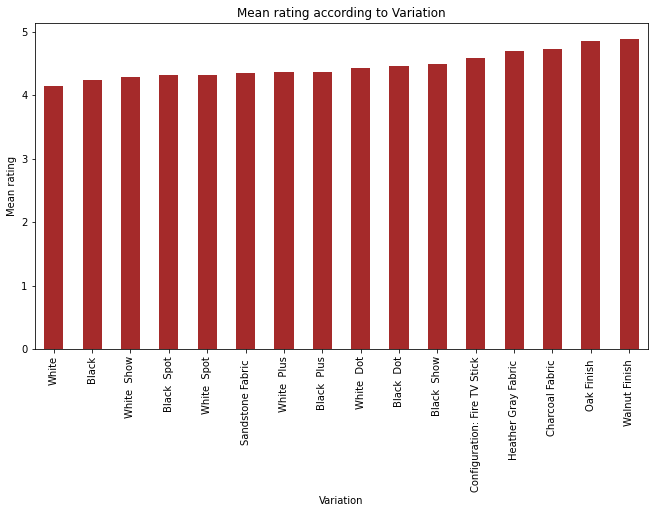

In [24]:
data.groupby('variation')['rating'].mean().sort_values().plot.bar(color='brown', figsize=(11,6))
plt.title('Mean rating according to Variation')
plt.xlabel('Variation')
plt.ylabel('Mean rating')

plt.show()

In [25]:
data['length'].describe()

count    3150.000000
mean      132.673651
std       182.526953
min         1.000000
25%        30.000000
50%        74.000000
75%       166.000000
max      2853.000000
Name: length, dtype: float64

[Text(0.5, 1.0, 'Distribution of length of review')]

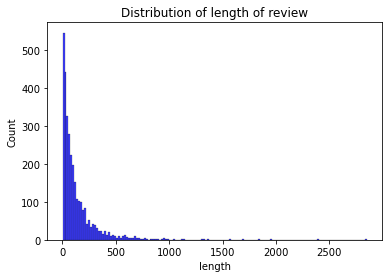

In [26]:
sns.histplot(data['length'],color='blue').set(title='Distribution of length of review')

[Text(0.5, 1.0, 'Distribution of length of review if feedback=0')]

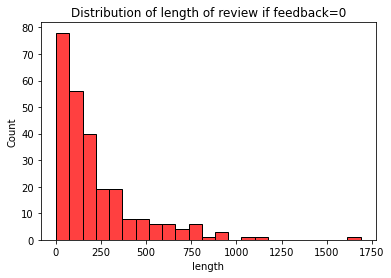

In [27]:
sns.histplot(data[data['feedback']==0]['length'],color='red').set(title='Distribution of length of review if feedback=0')

[Text(0.5, 1.0, 'Distribution of length of review if feedback=0')]

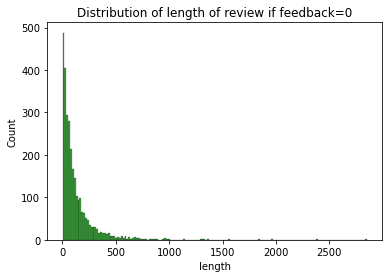

In [28]:
sns.histplot(data[data['feedback']==1]['length'],color='green').set(title='Distribution of length of review if feedback=0')

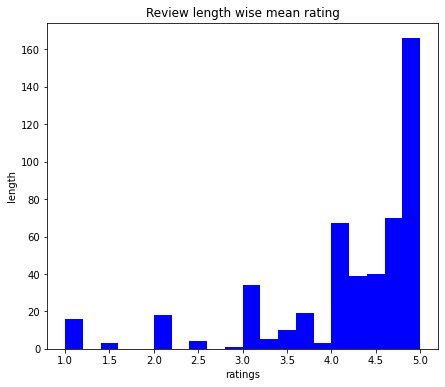

In [29]:
data.groupby('length')['rating'].mean().plot.hist(color='blue', figsize=(7,6), bins = 20)
plt.title('Review length wise mean rating')
plt.xlabel('ratings')
plt.ylabel('length')

plt.show()

In [30]:
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(data.verified_reviews)

In [31]:
pip install --upgrade wordcloud pillow

Note: you may need to restart the kernel to use updated packages.


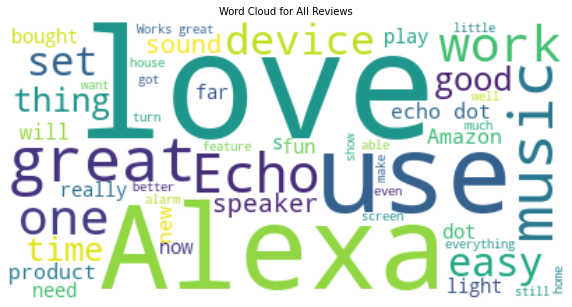

In [33]:

# Combine all reviews into a single string
reviews = " ".join(review for review in data['verified_reviews'])

# Generate the word cloud using default settings
wc = WordCloud(background_color='white', max_words=50).generate(reviews)

# Plot the word cloud
plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.title('Word Cloud for All Reviews', fontsize=10)
plt.axis('off')
plt.show()

In [42]:
# Combine and preprocess negative reviews
neg_reviews = " ".join([review for review in data[data['feedback'] == 0]['verified_reviews']])
neg_reviews = neg_reviews.lower().split()

# Combine and preprocess positive reviews
pos_reviews = " ".join([review for review in data[data['feedback'] == 1]['verified_reviews']])
pos_reviews = pos_reviews.lower().split()

# Find unique words in negative reviews
unique_negative = [x for x in neg_reviews if x not in pos_reviews]
unique_negative = " ".join(unique_negative)

# Find unique words in positive reviews
unique_positive = [x for x in pos_reviews if x not in neg_reviews]
unique_positive = " ".join(unique_positive)

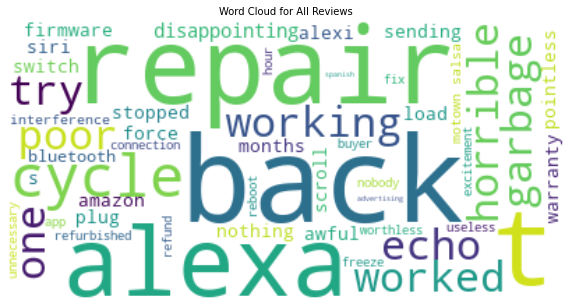

In [43]:
wc = WordCloud(background_color='white', max_words=50).generate(unique_negative)

# Plot the word cloud
plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.title('Word Cloud for All Reviews', fontsize=10)
plt.axis('off')
plt.show()

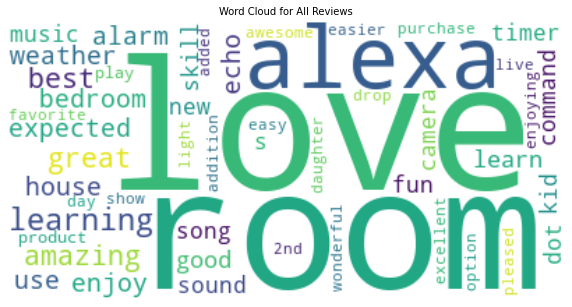

In [44]:
wc = WordCloud(background_color='white', max_words=50).generate(unique_positive)

# Plot the word cloud
plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.title('Word Cloud for All Reviews', fontsize=10)
plt.axis('off')
plt.show()

In [45]:
corpus = []
stemmer = PorterStemmer()
for i in range(0, data.shape[0]):
    review = re.sub('[^a-zA-Z]', ' ', data.iloc[i]['verified_reviews'])
    review = review.lower().split()
    review = [stemmer.stem(word) for word in review if not word in STOPWORDS]
    review = ' '.join(review)
    corpus.append(review)

In [46]:
cv = CountVectorizer(max_features = 2500)
x = cv.fit_transform(corpus).toarray()
y = data['feedback'].values

In [48]:
pickle.dump(cv, open('countVectorizer.pkl', 'wb'))

In [49]:
x.shape

(3150, 2500)

In [50]:
y.shape

(3150,)

In [51]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=15)

In [52]:
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (2205, 2500)
X_test shape: (945, 2500)
y_train shape: (2205,)
y_test shape: (945,)


In [53]:
X_train.max()

12

In [54]:
X_test.max()

10

In [57]:
scaler = MinMaxScaler()

X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

In [59]:
pickle.dump(scaler,open('scalar.pkl', 'wb'))

In [60]:
model_rf = RandomForestClassifier()
model_rf.fit(X_train_scl, y_train)

RandomForestClassifier()

In [61]:
model_rf.score(X_train_scl, y_train)

0.9941043083900227

In [62]:
model_rf.score(X_test_scl, y_test)

0.9439153439153439

In [63]:
y_preds = model_rf.predict(X_test_scl)

In [64]:
cm = confusion_matrix(y_test, y_preds)

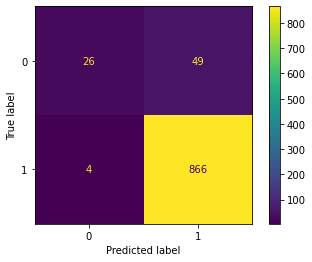

In [66]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_rf.classes_)
cm_display.plot()
plt.show()

In [67]:
accuracies = cross_val_score(estimator = model_rf, X = X_train_scl, y = y_train, cv = 10)

print("Accuracy :", accuracies.mean())
print("Standard Variance :", accuracies.std())

Accuracy : 0.9378712464006581
Standard Variance : 0.010113471862262264


In [68]:
params = {
    'bootstrap': [True],
    'max_depth': [80, 100],
    'min_samples_split': [8, 12],
    'n_estimators': [100, 300]
}

In [70]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV

# Define the StratifiedKFold cross-validator
cv_object = StratifiedKFold(n_splits=2)

# Define the parameter grid for GridSearchCV
params = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20]
}

# Initialize the RandomForestClassifier
model_rf = RandomForestClassifier(random_state=15)

# Set up the GridSearchCV with StratifiedKFold
grid_search = GridSearchCV(estimator=model_rf, param_grid=params, cv=cv_object, verbose=0, return_train_score=True)

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best cross-validation score: {grid_search.best_score_:.4f}')


Best parameters: {'max_depth': None, 'n_estimators': 100}
Best cross-validation score: 0.9270


In [71]:
print("Cross validation mean accuracy on train set : {}".format(grid_search.cv_results_['mean_train_score'].mean()*100))
print("Cross validation mean accuracy on test set : {}".format(grid_search.cv_results_['mean_test_score'].mean()*100))
print("Accuracy score for test set :", accuracy_score(y_test, y_preds))

Cross validation mean accuracy on train set : 95.71439109857678
Cross validation mean accuracy on test set : 92.10873907656564
Accuracy score for test set : 0.9439153439153439


In [72]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train_scl, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [73]:
print("Training Accuracy :", model_xgb.score(X_train_scl, y_train))
print("Testing Accuracy :", model_xgb.score(X_test_scl, y_test))

Training Accuracy : 0.9700680272108844
Testing Accuracy : 0.9407407407407408


In [74]:
y_preds = model_xgb.predict(X_test)

In [75]:
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[ 25  50]
 [ 10 860]]


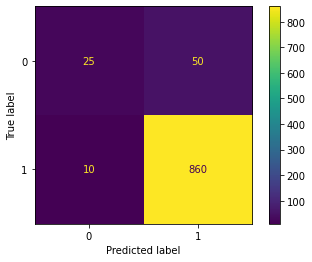

In [76]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_xgb.classes_)
cm_display.plot()
plt.show()

In [78]:
#Saving the XGBoost classifier
pickle.dump(model_xgb, open('model_xgb.pkl', 'wb'))

In [79]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train_scl, y_train)

DecisionTreeClassifier()

In [80]:
print("Training Accuracy :", model_dt.score(X_train_scl, y_train))
print("Testing Accuracy :", model_dt.score(X_test_scl, y_test))

Training Accuracy : 0.9941043083900227
Testing Accuracy : 0.9068783068783068


In [81]:
y_preds = model_dt.predict(X_test)

In [82]:
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[ 36  39]
 [ 79 791]]


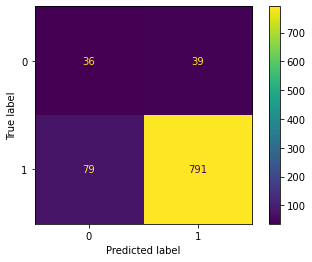

In [83]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_dt.classes_)
cm_display.plot()
plt.show()